In [8]:
import pandas as pd
import geopandas as gpd
import numpy as np
import altair as alt
import hvplot
# This will add the .hvplot() function to your DataFrame!
import hvplot.pandas

from matplotlib import pyplot as plt
# Needed to line up the colorbar properly
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Import holoviews too
import holoviews as hv

##  Bring in the data

In [19]:
citywide = pd.read_csv(r'.\data\summarystats\CityWideStopStats.csv')

In [10]:
city_limits = gpd.read_file(r'.\data\City_Limits\City_Limits.shp').to_crs(epsg=3857)

In [11]:
planning = gpd.read_file(r'.\data\Planning_Districts-shp\Planning_Districts.shp').to_crs(epsg=3857)

In [12]:
planning.head()

,OBJECTID_1,OBJECTID,DIST_NAME,ABBREV,Shape__Are,Shape__Len,PlanningDi,DaytimePop,geometry
0,1,14,River Wards,RW,2.107270e+08,66931.595020,None,None,"POLYGON ((-8359869.117 4866662.975, -8359745.2..."
1,2,3,North Delaware,NDEL,2.700915e+08,89213.074378,None,None,"POLYGON ((-8346912.719 4873739.208, -8346890.6..."
2,3,0,Lower Far Northeast,LFNE,3.068529e+08,92703.285159,None,None,"POLYGON ((-8345002.705 4882999.341, -8344992.2..."
3,4,9,Central,CTR,1.782880e+08,71405.143450,None,None,"POLYGON ((-8365427.328 4861196.536, -8365342.4..."
4,5,10,University Southwest,USW,1.296468e+08,65267.676141,None,None,"POLYGON ((-8369825.093 4860621.658, -8369716.2..."


In [13]:
north = planning[(planning["DIST_NAME"] == "North") |(planning["DIST_NAME"] =="Upper North")| (planning["DIST_NAME"] =="Lower North")]
three = planning[(planning["DIST_NAME"] == "North") |(planning["DIST_NAME"] =="Upper North")| (planning["DIST_NAME"] =="Lower North")|(planning["DIST_NAME"] =="Central")]
no = planning[(planning["DIST_NAME"] == "North")] 
no2 = planning[(planning["DIST_NAME"] =="Upper North")] 
no3 = planning[(planning["DIST_NAME"] =="Lower North")]
center = planning[(planning["DIST_NAME"] =="Central")]


In [14]:
from shapely.geometry import Polygon
from shapely.ops import cascaded_union


## merging polygons

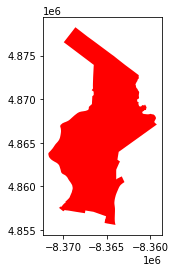

In [15]:
polygons = [center["geometry"], no["geometry"], no2["geometry"], no3["geometry"]]
boundary = gpd.GeoSeries(cascaded_union(three["geometry"]))
boundary.plot(color = 'red')
plt.show()

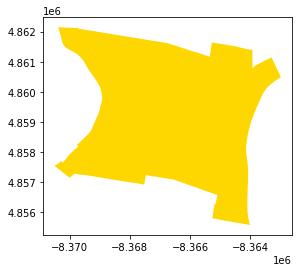

In [16]:
center.plot(color = 'gold')
plt.show()

C:\Users\brine\miniconda3\envs\musa-550-fall-2021\lib\site-packages\geopandas\geodataframe.py:182: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


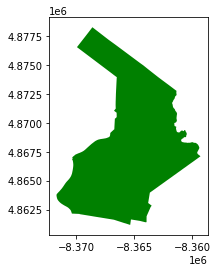

In [17]:
north.g = gpd.GeoSeries(cascaded_union(north["geometry"]))
north.g.plot(color = 'green')
plt.show()

## Prep the CityWide Hex Plot

In [20]:
# Create the Point() objects
citywide['geometry'] = gpd.points_from_xy(citywide['stop_lon'], citywide['stop_lat'])

# Turn into GeoDataFrame
citywide = gpd.GeoDataFrame(citywide, geometry="geometry", crs="EPSG:4326")

# make sure we remove missing geometries
citywide = citywide.dropna(subset=['geometry'])

# Convert crs 

citywide = citywide.to_crs(epsg=3857)
city_limits = city_limits.to_crs(citywide.crs)

# trim citywide data to citylimits

In [84]:
# Remove any complaints that are outside the city limits
citywide_city = gpd.sjoin(citywide, city_limits, op='within', how='inner')


In [85]:
citywide_city['x'] = citywide_city.geometry.x
citywide_city['y'] = citywide_city.geometry.y
avgon = citywide_city[['x', 'y', 'Total Avg. Ons', 'stop_namecleanstop_name']]
avgoffs = citywide_city[['x', 'y', 'Total Avg. Offs', 	'stop_namecleanstop_name']]

In [86]:
avgon.columns = avgon.columns.get_level_values(0)
avgoffs.columns = avgoffs.columns.get_level_values(0)

## trim to study area 

In [21]:
# Remove any complaints that are outside the city limits
planarea = gpd.sjoin(citywide, three, op='within', how='inner')


In [23]:
planarea['x'] = planarea.geometry.x
planarea['y'] = planarea.geometry.y
avgon_plan = planarea[['x', 'y', 'Total Avg. Ons', 'stop_namecleanstop_name']]
avgoffs_plan = planarea[['x', 'y', 'Total Avg. Offs', 	'stop_namecleanstop_name']]

In [25]:
city_limits.head()

,OBJECTID,Shape__Are,Shape__Len,geometry
0,1,0.038911,1.259687,"POLYGON ((-8350627.975 4886006.887, -8350582.8..."


In [87]:
city = city_limits.hvplot(geo=True, crs="epsg:3857", alpha= .5, line_color="black", color="NULL", line_width=2
)


In [90]:
onhexb = citywide.hvplot.hexbin(x='x', 
                      y='y', 
                      C='Total Avg. Ons',
                      #reduce_function=np.median,
                      #logz=True, 
                      geo=True,
                     crs='EPSG:3857',
                      gridsize=40,
                      cmap='viridis',
                       hover_cols = "all")

In [91]:
onhexb*city

:Overlay
   .HexTiles.I :HexTiles   [x,y]   (Total Avg. Ons,index,stop_namecleanstop_name,Total Avg. Ons,Total Avg. Offs,Overall Mean Avg. Ons,Overall Mean Avg. Offs,stop_lat,stop_lon,index_right,OBJECTID,Shape__Are,Shape__Len,x,y)
   .Polygons.I :Polygons   [Longitude,Latitude]

In [98]:
citywide.head()


,stop_namecleanstop_name,Total Avg. Ons,Total Avg. Offs,Overall Mean Avg. Ons,Overall Mean Avg. Offs,stop_lat,stop_lon,geometry,index_right,OBJECTID,Shape__Are,Shape__Len,x,y
6,10th St & Bigler St,0.475083,0.873754,0.237542,0.436877,39.913563,-75.165174,POINT (-8367348.895 4853389.429),0,1,0.038911,1.259687,-8.367349e+06,4.853389e+06
7,10th St & Bigler St,1.000000,0.950000,0.500000,0.475000,39.913224,-75.165066,POINT (-8367336.873 4853340.229),0,1,0.038911,1.259687,-8.367337e+06,4.853340e+06
8,10th St & Butler St,0.045455,0.000000,0.022727,0.000000,40.009870,-75.143896,POINT (-8364980.239 4867376.665),0,1,0.038911,1.259687,-8.364980e+06,4.867377e+06
9,10th St & Butler St,0.181818,0.000000,0.090909,0.000000,40.010039,-75.144026,POINT (-8364994.710 4867401.227),0,1,0.038911,1.259687,-8.364995e+06,4.867401e+06
10,10th St & Champlost St,0.200000,0.277778,0.100000,0.138889,40.043383,-75.136596,POINT (-8364167.607 4872248.583),0,1,0.038911,1.259687,-8.364168e+06,4.872249e+06


In [26]:

data = [['BGE', 
         -75.150997, 
         40.009497]]

xsect = pd.DataFrame(data, columns = ['AREA','lon', 'lat']) 
xsect["geometry"] = gpd.points_from_xy(xsect['lon'], xsect['lat'])
xsect = gpd.GeoDataFrame(xsect, geometry="geometry", crs="EPSG:4326")
xsect=xsect.to_crs(citywide.crs)



In [33]:
center.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

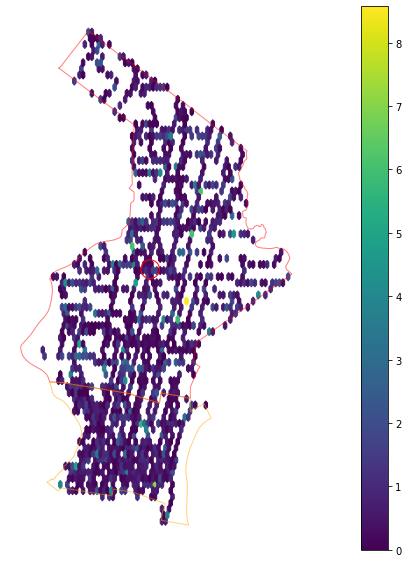

In [45]:
# create the axes
fig, ax = plt.subplots(figsize=(20, 10))


# Extract out the x/y coordindates of the Point objects
xcoords = planarea.geometry.x
ycoords = planarea.geometry.y

# Plot a hexbin chart
hex_vals = ax.hexbin(xcoords, ycoords, gridsize=70, C=planarea["Total Avg. Ons"])

# Add the  geometry boundaries
#city_limits.plot(ax=ax, facecolor="none", edgecolor="k", linewidth=1)
xsect.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1, markersize=350, marker='o')
north.g.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1, alpha=0.5)
center.plot(ax=ax, facecolor="none", edgecolor="orange", linewidth=1, alpha=0.5)
# add a colorbar and format
fig.colorbar(hex_vals, ax=ax)
ax.set_axis_off()
ax.set_aspect("equal")

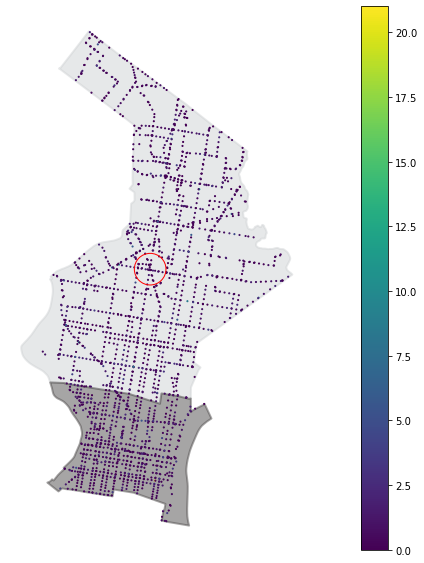

In [71]:
# create the axes
fig, ax = plt.subplots(figsize=(20, 10))

north.g.plot(ax=ax, facecolor="#cfd2d4", edgecolor="#cfd2d4", linewidth=2, alpha=0.5)
center.plot(ax=ax, facecolor="#4f4c4c", edgecolor="#4f4c4c", linewidth=2, alpha=0.5)
planarea.plot(ax=ax,
              column ="Total Avg. Ons",
              marker=".", markersize=5,
                legend=True)

# Add the  geometry boundaries
#city_limits.plot(ax=ax, facecolor="none", edgecolor="k", linewidth=1)

xsect.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1, markersize=1000, marker='o')

# add a colorbar and format
#fig.colorbar(vals, ax=ax)
ax.set_axis_off()
ax.set_aspect("equal")

In [106]:
north

,OBJECTID_1,OBJECTID,DIST_NAME,ABBREV,Shape__Are,Shape__Len,PlanningDi,DaytimePop,geometry
6,7,18,Upper North,UNO,2.227549e+08,74155.453511,None,None,"POLYGON ((-8366309.375 4876518.602, -8366182.5..."
8,9,15,North,NOR,2.394755e+08,75031.769136,None,None,"POLYGON ((-8361172.324 4869164.273, -8361136.8..."
17,18,13,Lower North,LNO,1.643847e+08,58947.148842,None,None,"POLYGON ((-8369763.333 4866003.094, -8369773.5..."


In [126]:
plan = planarea.hvplot( x='x', 
                      y='y', 
                      color='Overall Mean Avg. Offs',
                      geo=True,
                     crs='EPSG:3857',
                      cmap='viridis',
                      hover_cols = ["stop_namecleanstop_name"],
                      width=800, height=600)

npg = north.hvplot( geo=True, crs="epsg:3857", color="#cfd2d4", line_color="none", line_width=2, alpha=0.5)
cpg = center.hvplot( geo=True, crs="epsg:3857", color="#4f4c4c", line_color="#4f4c4c", line_width=2, alpha=0.5)


# Add the  geometry boundaries
#city_limits.plot(ax=ax, facecolor="none", edgecolor="k", linewidth=1)

xsectg = xsect.hvplot( geo=True, crs="epsg:3857", color="none", line_color="red", line_width=1, size=100)


In [127]:
npg * cpg * plan * xsectg

:Overlay
   .Polygons.I  :Polygons   [Longitude,Latitude]
   .Polygons.II :Polygons   [Longitude,Latitude]
   .Points.I    :Points   [x,y]   (Overall Mean Avg. Offs,stop_namecleanstop_name)
   .Points.II   :Points   [Longitude,Latitude]

In [ ]:
## Trying to get the different sections 

In [156]:
stopstats = pd.read_csv(r'.\data\summarystats\StopStatsSummary.csv')
nostopstats = pd.read_csv(r'.\data\summarystats\NorthStopStats.csv')
cstopstats = pd.read_csv(r'.\data\summarystats\CenterStopStats.csv')
bgestopstats = pd.read_csv(r'.\data\summarystats\BGEStopStats.csv')
citystopstats = pd.read_csv(r'.\data\summarystats\CityWideStopStats.csv')

In [169]:
citystopstats["logoff"]= np.log10(citystopstats["Overall Mean Avg. Offs"]+1)
citystopstats["logon"]= np.log10(citystopstats["Overall Mean Avg. Ons"]+1)


In [193]:
stopstats.columns[:-5]

Index(['cleanstop_name', 'Total Avg. Ons', 'Total Avg. Offs'], dtype='object')

In [155]:
import seaborn as sns

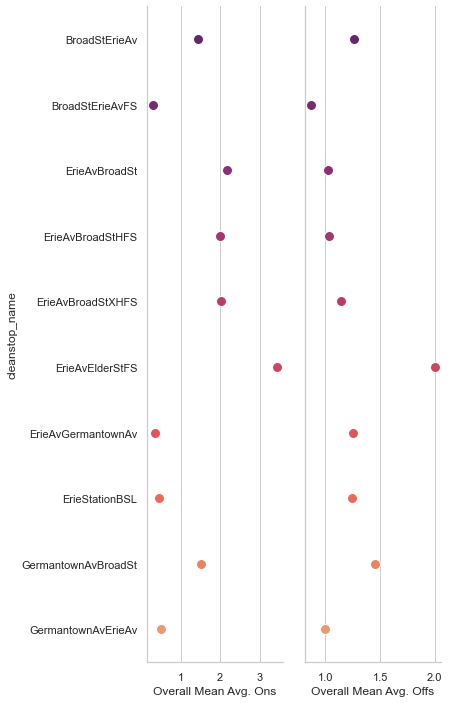

In [191]:
sns.set_theme(style="whitegrid")

# Load the dataset


# Make the PairGrid
g = sns.PairGrid(bgestopstats,
                 x_vars=citystopstats.columns[3:5], y_vars=["cleanstop_name"],
                 height=10, aspect=.25)
# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

TypeError: unsupported operand type(s) for |: 'AxesSubplot' and 'AxesSubplot'

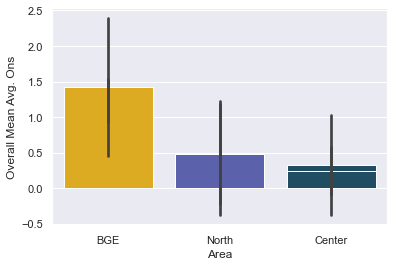

In [219]:
cmap = ["#fcba03", "#4f56b8", "#16506e"]
sns.set_theme(style="darkgrid")
sns.barplot(data= stopstats, y="Overall Mean Avg. Offs", x="Area", estimator=np.mean, ci="sd", palette=cmap)


<AxesSubplot:xlabel='Area', ylabel='Overall Mean Avg. Ons'>

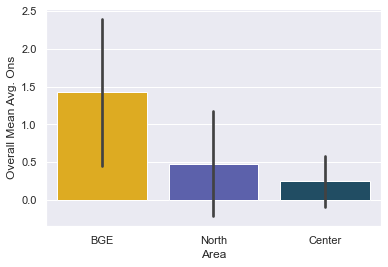

In [216]:
cmap = ["#fcba03", "#4f56b8", "#16506e"]
sns.set_theme(style="darkgrid")
sns.barplot(data= stopstats, y="Overall Mean Avg. Ons", x="Area", estimator=np.mean, ci="sd", palette=cmap)

In [230]:
import altair as alt

url = 'stopstats.json'
stopstats.to_json(url, orient='records')

off = alt.Chart(url).mark_bar().encode(
    x='Area',
    y='Overall Mean Avg. Offs'
)


on = alt.Chart(url).mark_bar().encode(
    x='Area:N',
    y='Overall Mean Avg. Ons:Q'
)


chart = off|on
on = on.to_dict()

In [196]:
stopstat3 = stopstats.melt('Area', var_name='a', value_name='b')

In [197]:
stopstat3.head()


,Area,a,b
0,BGE,cleanstop_name,BroadStErieAv
1,BGE,cleanstop_name,BroadStErieAvFS
2,BGE,cleanstop_name,ErieAvBroadSt
3,BGE,cleanstop_name,ErieAvBroadStHFS
4,BGE,cleanstop_name,ErieAvBroadStXHFS


In [154]:


ax = sns.catplot(
    data=stopstats, 
    kind = "violin",
    x="Area", 
    y="Overall Mean Avg. Ons", 
    hue="sex", 
    split=True,
    palette = "Dark2"
)
ax.set_xticklabels(rotation = 10)

AttributeError: 'PlotAccessor' object has no attribute 'violin'

In [3]:
import osmnx as ox

In [166]:
philly = ox.geocode_to_gdf('Philadelphia, PA, USA')

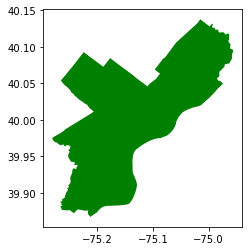

In [170]:
philly.plot(color = 'green')
plt.show()

In [7]:
G_boundary = ox.graph_from_polygon(boundary, network_type='all')

NameError: name 'boundary' is not defined

In [6]:
G_projected = ox.project_graph(G_boundary)
ox.plot_graph(G_projected, node_size=0)

KeyboardInterrupt: 

# this is just the context map below

<AxesSubplot:>

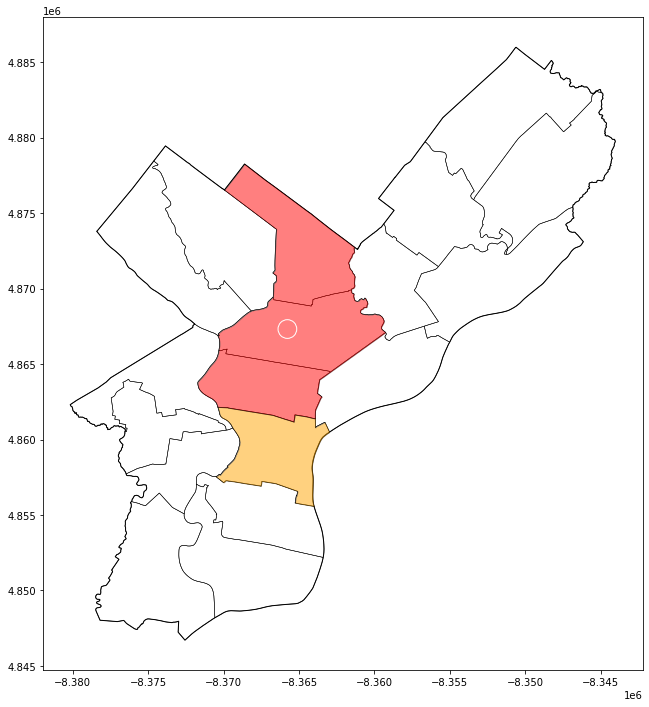

In [164]:
# create the axes
fig, ax = plt.subplots(figsize=(12, 12))


# Add the zillow geometry boundaries
city_limits.plot(ax=ax, facecolor="none", edgecolor="k", linewidth=1)
planning.plot(ax=ax, facecolor="none", edgecolor="k", linewidth=0.5)
north.g.plot(ax=ax, facecolor="red", edgecolor="k", linewidth=0.5, alpha=0.5)
center.plot(ax=ax, facecolor="orange", edgecolor="k", linewidth=0.5, alpha=0.5)
xsect.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=1, markersize=350, marker='o')

ax.set_axis_off
